In [1]:
import glob
import numpy as np

In [2]:
frds = glob.glob('output/ccx/*/*.frd')
dats = glob.glob('output/ccx/*/*.dat')

In [3]:
# dats = dats[1:]
# frds = frds[1:]

In [4]:
from djccx.read_dat import read_dat
from djccx.frd.readfrd import readfrd

In [5]:
t_l = 0.475 #  Espesor de la capa [mm]
t_n = 2.934
A_s = 0.283 # mm^2

r = 3*t_l/8 
d = (A_s - np.pi*r**2)/(2*r) # Area de la capa [mm^2]
params_composite ={
    "r"         :  r,
    "d"         :  d,
    "h"         :  t_l,
    "z0"        :  0,
    "density"   : 5,
}
params_ccx = {
    "epsilon" : 0.1,
    "x_fixed" : True
}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [6]:
ni = [1,2,2,2,3,3]
ni = [1,1,1,1] # Consideramos Adouble

In [7]:


def compute_E_eff(iffiles,ni):

    ancho = params_composite["z0"]*0.5 + ni*params_composite["h"]
    largo = 10 
    A = ancho*largo
    try:
        ifrd = readfrd(iffiles)
    except:
        print("Error reading frd file")
        return 0
    df = ifrd["data"]
    Sapl = np.sum(df["F2"]*(df["y"] > df["y"].mean()))/A

    E_eff = Sapl / params["ccx"]["epsilon"]
    return E_eff

E_effs = [compute_E_eff(f,ini) for f,ini in zip(frds,ni)]
#E_effs = [compute_E_eff(f,ini) for f,ini in zip(frds[0:1],ni[0:1])]
E_effs = np.array(E_effs)*1e-3

In [8]:
frds
E_effs = [ E_effs[2], E_effs[3], E_effs[0], E_effs[1] ]

In [9]:
frds = [ frds[2], frds[3], frds[0], frds[1] ]
frds

['output/ccx\\X\\main.frd',
 'output/ccx\\Y\\main.frd',
 'output/ccx\\SX\\main.frd',
 'output/ccx\\SY\\main.frd']

In [10]:
names = [f.split("/")[-1].split("\\")[-2] for f in frds]
names

['X', 'Y', 'SX', 'SY']

In [37]:
E_effs

[np.float64(1.2088274485717199),
 np.float64(6.466444207572218),
 np.float64(1.1275444871168847),
 np.float64(1.1351080246557104)]

In [38]:

E_X  = 1.27281
E_SX = 1.15202
E_Y  = 6.37512
E_SY = 1.15942

E_target = [ E_X , E_Y , E_SX , E_SY ]
E_target = np.array(E_target)


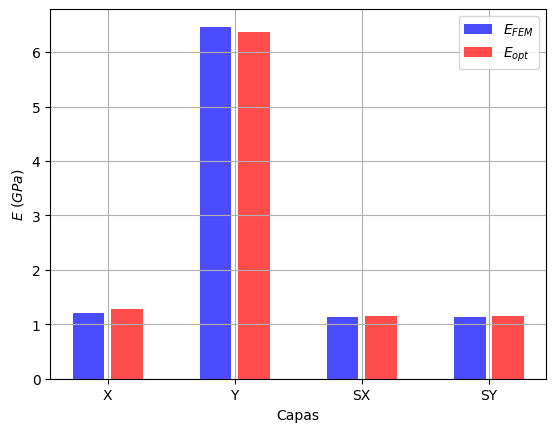

In [39]:
# bar plot 
from matplotlib import pyplot as plt

xrange = np.arange(len(E_effs))
plt.bar(xrange-0.15, E_effs,
         tick_label=names, color='blue', alpha=0.7,label=r"$E_{FEM}$",width=0.25)
plt.bar(xrange+ 0.15, E_target,
         tick_label=names, color='red', alpha=0.7,label=r"$E_{opt}$",width=0.25)

plt.xticks(xrange, names, rotation=0)
plt.ylabel(r"$E\ (GPa)$")
plt.xlabel("Capas")
plt.grid()
plt.legend()

In [40]:
E_effs

[np.float64(1.2088274485717199),
 np.float64(6.466444207572218),
 np.float64(1.1275444871168847),
 np.float64(1.1351080246557104)]

In [41]:
E_target

array([1.27281, 6.37512, 1.15202, 1.15942])

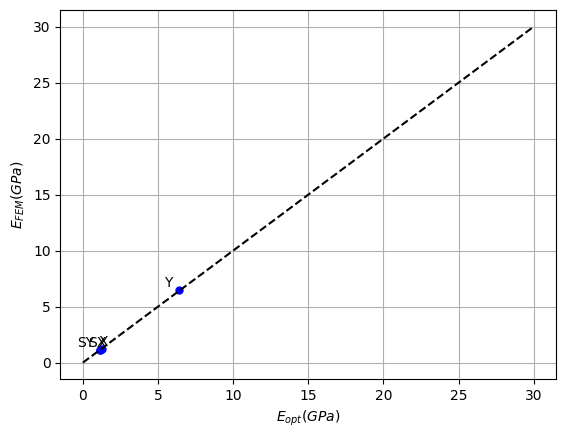

In [42]:
# 1vs1 

plt.figure()
plt.plot(E_target,E_effs, 'o', color='blue', label=r"$E_{FEM}$ vs $E_{target}$",ms=5)
plt.plot([0, 30], [0, 30], 'k--', label='1:1')
plt.ylabel(r"$E_{FEM} (GPa)$")
plt.xlabel(r"$E_{opt} (GPa)$")
# text 
for i, txt in enumerate(names):

    if i % 2 == 0:
        disp =  0.4
    else:
        disp = -0.4
    plt.annotate(txt, (E_target[i]+disp, E_effs[i]), fontsize=10, ha='right', va='bottom')
# plt.xlim(0, 10)
# plt.ylim(0, 10)
plt.grid()

In [45]:
t_l = 0.475 #  Espesor de la capa [mm]
t_n = 2.934

r = 3*t_l/8 
d = (A_s - np.pi*r**2)/(2*r) # Area de la capa [mm^2]

E_resina =  0.63*1e3 
E_carbon = 16.69*1e3
E_nucleo = 880


L = 10 # Largo de la capa [mm]


### Prediccion Capa Y 

In [46]:
N_hilos = 6
A_Y = np.pi*r**2 + 2*r*d # Area de la capa [mm^2]
A_Y = N_hilos*A_Y # Area total de la capa [mm^2] 
A_t = L*t_l # Area de la capa [mm^2]

v_frac = A_Y/A_t # Fraccion de volumen de la capa
print("Area de la capa: ",A_t, " mm^2")
print("Area de la capa con hilos: ",A_Y, " mm^2")
print("Fraccion de volumen de fibra de la capa: ", round(v_frac*100,2), "%")
print("Fraccion de volumen de resina de la capa: ",round((1-v_frac)*100,2), "%")


Area de la capa:  4.75  mm^2
Area de la capa con hilos:  1.698  mm^2
Fraccion de volumen de fibra de la capa:  35.75 %
Fraccion de volumen de resina de la capa:  64.25 %


In [47]:
def ModelY(v_frac):
    E = (1- v_frac)*E_resina + v_frac*E_carbon
    return 1e-3*E

print("Modulo de Young de la capa (Analitico): ", round(ModelY(v_frac),2), " GPa")
names
# find Y 
id_Y = names.index("Y")
E_Y = E_effs[id_Y]
print("Modulo de Young de la capa (FEM): ", round(E_Y,2), " GPa")

Modulo de Young de la capa (Analitico):  6.37  GPa
Modulo de Young de la capa (FEM):  6.47  GPa


In [48]:
Error_Y = E_Y - ModelY(v_frac)
print("Error en el modulo de Young de la capa (FEM): ", round(Error_Y,2), " GPa")
Error_Y = Error_Y/E_Y*100
print("Error en el modulo de Young de la capa (FEM): ", round(Error_Y,2), " %")

Error en el modulo de Young de la capa (FEM):  0.1  GPa
Error en el modulo de Young de la capa (FEM):  1.48  %


In [49]:
def ModelX(v_frac):
    f_c = 6*(d+2*r)/L
    E_h = 1/(f_c/E_carbon + (1-f_c)/E_resina)

    E = (2*E_resina*(t_l - 2*r) + 2*E_h*r)/t_l
    return 1e-3*E

In [50]:
print("Modulo de Young de la capa (Analitico): ", round(ModelX(v_frac),2), " GPa")
names
# find X
id_X = names.index("X")
E_X = E_effs[id_X]
print("Modulo de Young de la capa (FEM): ", round(E_X,2), " GPa")

Modulo de Young de la capa (Analitico):  1.27  GPa
Modulo de Young de la capa (FEM):  1.21  GPa


In [51]:
print("Error en el modulo de Young de la capa (FEM): ", round(E_X - ModelX(v_frac),2), " GPa")
Error_X = abs(E_X - ModelX(v_frac))/E_X*100
print("Error en el modulo de Young de la capa (FEM): ", round(Error_X,2), " %")


Error en el modulo de Young de la capa (FEM):  -0.06  GPa
Error en el modulo de Young de la capa (FEM):  4.67  %


In [52]:
v_frac

0.35747368421052633